In [7]:
import plotly.graph_objects as go

In [1]:
# this is our preamble cell :
# remember to check for anything missing 
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib 


import category_encoders as ce
from sklearn.model_selection import train_test_split


from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder

from sklearn import cluster
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree

# from shap import TreeExplainer, initjs, force_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [2]:
# OK, importing and minor cleaning first. 

dfreal = pd.read_csv('True.csv',
                    parse_dates = ['date'])
#                    index_col = 'date')
dfreal['Fake'] = 0
print('Real data shape: ', dfreal.shape)

dffake = pd.read_csv('Fake.csv',
                    parse_dates = ['date'])
#                    index_col = 'date')

dffake['Fake'] = 1
print('Fake data shape: ', dffake.shape)

Real data shape:  (21417, 5)
Fake data shape:  (23481, 5)


In [3]:
# this is proof that only the fake csv has garbage dates in it, which is why none of the parse dates worked. 
dfreal['date'].value_counts()
#.tail(50)

2017-12-20    182
2017-12-06    166
2017-11-30    162
2017-11-09    158
2017-10-13    155
             ... 
2016-09-11      1
2016-05-14      1
2016-05-30      1
2016-08-06      1
2016-09-03      1
Name: date, Length: 716, dtype: int64

In [4]:
dffake['date'].value_counts()

May 10, 2017                                                                                                                                             46
May 5, 2016                                                                                                                                              44
May 6, 2016                                                                                                                                              44
May 26, 2016                                                                                                                                             44
May 11, 2016                                                                                                                                             43
                                                                                                                                                         ..
December 9, 2017                                                

In [5]:

# dffake = 
comma_list = pd.DataFrame(dffake['date'].str.find(','))

comma_list.value_counts()
comma_list.shape

(23481, 1)

In [6]:
# df = df[~df['your column'].isin(['list of strings'])]
# http = ['http',".com"]
# dffake2 = dffake[~dffake.date.isin(http)]

searchfor = ['http', '-', 'MSNBC']
dffake2 = dffake[~dffake['date'].str.contains('|'.join(searchfor))]

In [7]:
dffake2['date'].value_counts()

May 10, 2017         46
May 5, 2016          44
May 26, 2016         44
May 6, 2016          44
May 11, 2016         43
                     ..
Jun 21, 2015          1
November 12, 2017     1
November 19, 2017     1
November 20, 2017     1
Jul 18, 2015          1
Name: date, Length: 1669, dtype: int64

In [8]:
print(dffake2.shape)
print(dfreal.shape)

(23436, 5)
(21417, 5)


In [9]:
#dffake2['date'] = pd.to_datetime(dffake2['date'], format='%m%d%y')
# dffake2['date'] = dffake2['date'].astype('datetime64[ns]')

In [10]:
# now I'll trim those up so they are the same length - 
# 50% real 50% fake seems reasonable right?

dfreal_trimmed = dfreal[-21_400 :]
print('Real trimmed shape: ', dfreal_trimmed.shape)

dffake_trimmed = dffake2[-21_400 :]
print('Fake trimmed shape: ', dffake_trimmed.shape)

# and now combine them into one dataframe:
df_joined = dfreal_trimmed.append(dffake_trimmed, ignore_index=True)

df_joined['date'] = pd.to_datetime(df_joined['date'])

print()
print('Combined and trimmed (equal parts Real and Fake) shape: ', df_joined.shape)
print()
#print(df_joined.head(1))
#df_joined.head(25)

Real trimmed shape:  (21400, 5)
Fake trimmed shape:  (21400, 5)

Combined and trimmed (equal parts Real and Fake) shape:  (42800, 5)



In [11]:
df_joined['date'].value_counts()

# Holy Smokes I think all the date times are clean. 
# Let's never spend 2 days on that again. 

2017-12-20    194
2017-12-06    180
2017-11-09    178
2017-11-30    175
2017-10-13    171
             ... 
2015-06-21      1
2015-06-07      1
2015-07-19      1
2015-07-18      1
2015-04-02      1
Name: date, Length: 1004, dtype: int64

In [12]:

# All URL's and Wrong-Dates seem to be corrected. Finally.  
# X and y are still not the same length - need to fix that... 



In [13]:
df_joined.head()

,title,text,subject,date,Fake
0,"Trump on Twitter (Dec 26) - Hillary Clinton, T...",The following statements were posted to the ve...,politicsNews,2017-12-26,0
1,U.S. appeals court rejects challenge to Trump ...,(Reuters) - A U.S. appeals court in Washington...,politicsNews,2017-12-26,0
2,Treasury Secretary Mnuchin was sent gift-wrapp...,(Reuters) - A gift-wrapped package addressed t...,politicsNews,2017-12-24,0
3,Federal judge partially lifts Trump's latest r...,WASHINGTON (Reuters) - A federal judge in Seat...,politicsNews,2017-12-24,0
4,Exclusive: U.S. memo weakens guidelines for pr...,NEW YORK (Reuters) - The U.S. Justice Departme...,politicsNews,2017-12-23,0


## *I don't think we'll use this but here's a Count Vectorizer just in case:*

In [14]:
# instantiate the count vectorizer:
cv = CountVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 50, max_df = 0.95 , min_df = 0.01 )

# here's a function to return a dataframe:

def create_term_matrix(message_list, vectorizer):
    doc_term_df = vectorizer.fit_transform(message_list)
    return DataFrame(doc_term_df.toarray(),
                     columns=vectorizer.get_feature_names())

# now here's the actual "thing":

df_joined_CountVector = create_term_matrix(df_joined['text'], cv)

df_joined_CountVector.describe()

,according,american,called,campaign,clinton,country,court,democratic,did,donald,...,support,time,told,trump,united,washington,week,white,year,years
count,42800.000000,42800.000000,42800.000000,42800.000000,42800.000000,42800.000000,42800.000000,42800.000000,42800.000000,42800.000000,...,42800.000000,42800.000000,42800.000000,42800.000000,42800.000000,42800.000000,42800.000000,42800.000000,42800.000000,42800.000000
mean,0.315047,0.360117,0.295794,0.483505,0.618014,0.389159,0.329299,0.303575,0.369673,0.590771,...,0.297734,0.460935,0.529416,2.523014,0.536028,0.422009,0.299813,0.483178,0.557126,0.386589
std,0.787854,1.065031,0.658973,1.347394,2.304309,0.904674,1.353023,0.888128,0.797977,1.020930,...,0.768017,0.910293,0.939773,4.386813,1.283105,0.954925,0.675320,1.305252,1.120097,0.890714
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,20.000000,48.000000,10.000000,31.000000,67.000000,26.000000,43.000000,18.000000,20.000000,32.000000,...,24.000000,28.000000,13.000000,73.000000,42.000000,35.000000,10.000000,36.000000,27.000000,61.000000


In [15]:
# Tf-IDF Vectorizer are the same results are doing a Count Vectorizer followed by a Tf-IDF Transform. 
# GradientBoostingClassifier. Good thing we learned some params today. 
# 
# I still have questions regarding how to merge the results from this with my orginal df_joined(41,800 x 5) - so pin in that for now. 

# 
# create a dictionary for myself (ex: year and years same word) - (sisichen)
# find an NLP function that can cluster similiar words together - lookup common NLP functions - (sisichen)

# merging original frame and target vector with results so that I can train test split and fit model...
# Ngrams. They exist in the parameters for the vectorizer / model below... 

## *now for TF-IDF* - check for class weight = balanced

In [16]:
# alright, let's see if I can generate anything to show for myself re: TF-IDF Vectorizer... 

# instantiate:
tfidf = TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 50, min_df= 0.25 , max_df= 0.75)
# ngram_range=(1,2) - we're gonna play with the ngrams soon, be patient. 
def create_term_matrix(message_list, vectorizer):
    doc_term_df = vectorizer.fit_transform(message_list)
    return DataFrame(doc_term_df.toarray(),
                     columns=vectorizer.get_feature_names())

joined_tfid01 = create_term_matrix(df_joined['text'], tfidf)

joined_tfid01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42800 entries, 0 to 42799
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   did         42800 non-null  float64
 1   donald      42800 non-null  float64
 2   government  42800 non-null  float64
 3   house       42800 non-null  float64
 4   just        42800 non-null  float64
 5   like        42800 non-null  float64
 6   new         42800 non-null  float64
 7   news        42800 non-null  float64
 8   people      42800 non-null  float64
 9   president   42800 non-null  float64
 10  republican  42800 non-null  float64
 11  reuters     42800 non-null  float64
 12  said        42800 non-null  float64
 13  state       42800 non-null  float64
 14  states      42800 non-null  float64
 15  time        42800 non-null  float64
 16  told        42800 non-null  float64
 17  trump       42800 non-null  float64
 18  united      42800 non-null  float64
 19  washington  42800 non-nul

In [17]:
# ok an attempt to get it back into the original frame so we can train test split... 

#df_joined_tfidvect = df_joined 
#df_joined_tfidvect['tfidf'] 

#first drop text
df_joined_tfidvect = df_joined.drop(['text'], axis=1)

#fit it - sparse series
tfidf_fit = tfidf.fit_transform(df_joined['text'])
print(tfidf_fit.shape)

(42800, 22)


In [18]:
#dataframe (temporary, using pd.DataFrame and .toarray)
df1 = pd.DataFrame(tfidf_fit.toarray(), columns=tfidf.get_feature_names())


#concat (after drop) for resulting frame
df_joined_tfidvect = pd.concat([df_joined_tfidvect, df1], axis=1)

df_joined_tfidvect.shape

(42800, 26)

In [19]:
df_joined_tfidvect.head()

,title,subject,date,Fake,did,donald,government,house,just,like,...,said,state,states,time,told,trump,united,washington,year,years
0,"Trump on Twitter (Dec 26) - Hillary Clinton, T...",politicsNews,2017-12-26,0,0.00000,0.190346,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.432356,0.000000,0.524103,0.00000,0.000000,0.638174,0.000000
1,U.S. appeals court rejects challenge to Trump ...,politicsNews,2017-12-26,0,0.15181,0.123258,0.143941,0.0,0.000000,0.142809,...,0.250194,0.271940,0.697583,0.000000,0.000000,0.113127,0.14763,0.291545,0.000000,0.000000
2,Treasury Secretary Mnuchin was sent gift-wrapp...,politicsNews,2017-12-24,0,0.00000,0.222543,0.000000,0.0,0.000000,0.000000,...,0.150575,0.000000,0.000000,0.000000,0.719777,0.408504,0.00000,0.000000,0.000000,0.000000
3,Federal judge partially lifts Trump's latest r...,politicsNews,2017-12-24,0,0.00000,0.119426,0.139466,0.0,0.000000,0.000000,...,0.323220,0.131743,0.405537,0.000000,0.000000,0.548050,0.42912,0.141240,0.133467,0.147699
4,Exclusive: U.S. memo weakens guidelines for pr...,politicsNews,2017-12-23,0,0.00000,0.064380,0.075184,0.0,0.071809,0.000000,...,0.479166,0.000000,0.072873,0.219353,0.000000,0.118178,0.07711,0.000000,0.071950,0.000000


In [20]:
df_joined_thirdvector.drop(['subject'], axis=1, inplace=True)

# #df_joined_thirdvector['date'] = df_joined_thirdvector['date'].dt.year

df_joined_thirdvector.head()

NameError: name 'df_joined_thirdvector' is not defined

In [254]:
df_joined_thirdvector.head()

,did,donald,government,house,just,like,new,news,people,republican,...,time,told,trump,united,washington,year,years,subject,date,Fake
0,0.000000,0.195721,0.000000,0.0,0.000000,0.000000,0.207481,0.0,0.000000,0.000000,...,0.444565,0.000000,0.538902,0.000000,0.000000,0.656195,0.000000,politicsNews,2017,0
1,0.161714,0.131300,0.153333,0.0,0.000000,0.152126,0.139189,0.0,0.127157,0.320309,...,0.000000,0.000000,0.120508,0.157262,0.310567,0.000000,0.000000,politicsNews,2017,0
2,0.000000,0.250359,0.000000,0.0,0.000000,0.000000,0.265402,0.0,0.000000,0.000000,...,0.000000,0.809743,0.459563,0.000000,0.000000,0.000000,0.000000,politicsNews,2017,0
3,0.000000,0.132676,0.154940,0.0,0.000000,0.000000,0.140648,0.0,0.128490,0.161833,...,0.000000,0.000000,0.608856,0.476731,0.156911,0.148275,0.164086,politicsNews,2017,0
4,0.000000,0.073646,0.086004,0.0,0.082144,0.000000,0.936852,0.0,0.000000,0.000000,...,0.250922,0.000000,0.135186,0.088208,0.000000,0.082304,0.000000,politicsNews,2017,0


In [269]:
# ok, that's new for us... let's gooooooo

# X and y split



target = df_joined_thirdvector['Fake']

X = df_joined_thirdvector.drop(['Fake'], axis=1)

y = target

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (42800, 20)
y shape:  (42800,)


In [270]:
# this is silly but it's good form, so here's a baseline. 
print('Baseline :', df_joined_thirdvector['Fake'].value_counts().max()/len(df_joined_thirdvector['Fake']))

Baseline : 0.5


In [271]:
# train test split:

# leaving this code here in case I set up my target wrong. 
# X = df.drop(['target'],axis=1).values   # independant features
# y = df['target'].values					# dependant variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# doing 25/75 split and 42. 

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(24075, 20)
(24075,)
(8025, 20)
(8025,)
(10700, 20)
(10700,)


In [164]:
# # instantiate 2nd: much different mix max:
# tfidf2 = TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 100, min_df= 0.5 , max_df= 0.99)
# # ngram_range=(1,2) - we're gonna play with the ngrams soon, be patient. 
# def create_term_matrix(message_list, vectorizer):
#     doc_term_df = vectorizer.fit_transform(message_list)
#     return DataFrame(doc_term_df.toarray(),
#                      columns=vectorizer.get_feature_names())

# df_joined_tfidfvector2 = create_term_matrix(df_joined['text'], tfidf2)

# df_joined_tfidfvector2.describe()

In [242]:
# instantiate: once again, different min max. 

tfidf3 = TfidfVectorizer(stop_words = 'english', strip_accents ='ascii', max_features = 100, min_df= 0.25 , max_df= 0.5)
# ngram_range=(1,2) - we're gonna play with the ngrams soon, be patient. 
def create_term_matrix(message_list, vectorizer):
    doc_term_df = vectorizer.fit_transform(message_list)
    return DataFrame(doc_term_df.toarray(),
                     columns=vectorizer.get_feature_names())

df_joined_tfidfvector3 = create_term_matrix(df_joined['text'], tfidf3)

df_joined_tfidfvector3.head()


,did,donald,government,house,just,like,new,news,people,republican,state,states,time,told,trump,united,washington,year,years
0,0.000000,0.195721,0.000000,0.0,0.000000,0.000000,0.207481,0.0,0.000000,0.000000,0.000000,0.000000,0.444565,0.000000,0.538902,0.000000,0.000000,0.656195,0.000000
1,0.161714,0.131300,0.153333,0.0,0.000000,0.152126,0.139189,0.0,0.127157,0.320309,0.289683,0.743097,0.000000,0.000000,0.120508,0.157262,0.310567,0.000000,0.000000
2,0.000000,0.250359,0.000000,0.0,0.000000,0.000000,0.265402,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.809743,0.459563,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.132676,0.154940,0.0,0.000000,0.000000,0.140648,0.0,0.128490,0.161833,0.146360,0.450532,0.000000,0.000000,0.608856,0.476731,0.156911,0.148275,0.164086
4,0.000000,0.073646,0.086004,0.0,0.082144,0.000000,0.936852,0.0,0.000000,0.000000,0.000000,0.083360,0.250922,0.000000,0.135186,0.088208,0.000000,0.082304,0.000000


In [ ]:
# from pdpbox.pdp import pdp_isolate, pdp_plot
# that should be pip installed now. 
# also pip installed plotly. 


In [272]:
print(X_train.shape)
print(y_train.shape)

(24075, 20)
(24075,)


In [273]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24075 entries, 7784 to 6475
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   did         24075 non-null  float64
 1   donald      24075 non-null  float64
 2   government  24075 non-null  float64
 3   house       24075 non-null  float64
 4   just        24075 non-null  float64
 5   like        24075 non-null  float64
 6   new         24075 non-null  float64
 7   news        24075 non-null  float64
 8   people      24075 non-null  float64
 9   republican  24075 non-null  float64
 10  state       24075 non-null  float64
 11  states      24075 non-null  float64
 12  time        24075 non-null  float64
 13  told        24075 non-null  float64
 14  trump       24075 non-null  float64
 15  united      24075 non-null  float64
 16  washington  24075 non-null  float64
 17  year        24075 non-null  float64
 18  years       24075 non-null  float64
 19  date        24075 non-n

In [244]:
df_joined_thirdvector = pd.concat([df_joined_tfidfvector3, df_joined], axis=1)

In [274]:
df_joined_thirdvector.head()

,did,donald,government,house,just,like,new,news,people,republican,...,states,time,told,trump,united,washington,year,years,date,Fake
0,0.000000,0.195721,0.000000,0.0,0.000000,0.000000,0.207481,0.0,0.000000,0.000000,...,0.000000,0.444565,0.000000,0.538902,0.000000,0.000000,0.656195,0.000000,2017,0
1,0.161714,0.131300,0.153333,0.0,0.000000,0.152126,0.139189,0.0,0.127157,0.320309,...,0.743097,0.000000,0.000000,0.120508,0.157262,0.310567,0.000000,0.000000,2017,0
2,0.000000,0.250359,0.000000,0.0,0.000000,0.000000,0.265402,0.0,0.000000,0.000000,...,0.000000,0.000000,0.809743,0.459563,0.000000,0.000000,0.000000,0.000000,2017,0
3,0.000000,0.132676,0.154940,0.0,0.000000,0.000000,0.140648,0.0,0.128490,0.161833,...,0.450532,0.000000,0.000000,0.608856,0.476731,0.156911,0.148275,0.164086,2017,0
4,0.000000,0.073646,0.086004,0.0,0.082144,0.000000,0.936852,0.0,0.000000,0.000000,...,0.083360,0.250922,0.000000,0.135186,0.088208,0.000000,0.082304,0.000000,2017,0


In [302]:
# # Create pipeline
#X_train.drop(['tfidf'], axis=1, inplace=True)

from category_encoders import OneHotEncoder

model1 = Pipeline([
    #('vectorizer', TfidfVectorizer(lowercase=True, stop_words = 'english', strip_accents ='ascii', max_features = 20, ngram_range=(1,2))),
    #('dim_red', TruncatedSVD(n_components=19, random_state=42)),
    ('encoder', OrdinalEncoder()),
    ('predictor', GradientBoostingClassifier(random_state=42, verbose=1))
])

# Fit model to training data
model1.fit(X_train, y_train); 

print(model1.score(X_train, y_train))


      Iter       Train Loss   Remaining Time 
         1           1.3115            3.91s
         2           1.2504            3.89s
         3           1.1994            3.82s
         4           1.1554            3.82s
         5           1.1183            3.78s
         6           1.0830            3.75s
         7           1.0557            3.70s
         8           1.0305            3.66s
         9           1.0029            3.62s
        10           0.9828            3.57s
        20           0.8414            3.17s
        30           0.7646            2.78s
        40           0.7122            2.38s
        50           0.6764            1.99s
        60           0.6516            1.59s
        70           0.6338            1.19s
        80           0.6192            0.79s
        90           0.6061            0.40s
       100           0.5973            0.00s
0.8773416407061266


In [303]:
print(model1.score(X_val, y_val))

0.8654205607476636


In [304]:
X_train.columns

Index(['did', 'donald', 'government', 'house', 'just', 'like', 'new', 'news',
       'people', 'republican', 'state', 'states', 'time', 'told', 'trump',
       'united', 'washington', 'year', 'years', 'date'],
      dtype='object')

In [305]:
#X_test.drop(['tfidf'], axis=1, inplace=True)
print(model1.score(X_test, y_test))

0.8655140186915888


In [233]:
X_test.head()

,subject,date,did,donald,government,house,just,like,new,news,...,said,state,states,time,told,trump,united,washington,year,years
16200,worldnews,2017,0.300860,0.000000,0.0,0.581954,0.000000,0.00000,0.000000,0.601440,...,0.165280,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8480,politicsNews,2016,0.000000,0.078910,0.0,0.046998,0.132023,0.00000,0.041826,0.097144,...,0.347045,0.043524,0.044660,0.0,0.085074,0.869093,0.047257,0.000000,0.044094,0.000000
40924,left-news,2015,0.168575,0.000000,0.0,0.000000,0.152664,0.15858,0.000000,0.168497,...,0.185217,0.000000,0.000000,0.0,0.295123,0.000000,0.000000,0.161872,0.000000,0.338547
20379,worldnews,2017,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.612743,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7090,politicsNews,2016,0.000000,0.135727,0.0,0.000000,0.000000,0.00000,0.143882,0.000000,...,0.459171,0.000000,0.460889,0.0,0.000000,0.373712,0.487691,0.000000,0.303368,0.000000


In [234]:
X_test.columns

Index(['subject', 'date', 'did', 'donald', 'government', 'house', 'just',
       'like', 'new', 'news', 'people', 'president', 'republican', 'reuters',
       'said', 'state', 'states', 'time', 'told', 'trump', 'united',
       'washington', 'year', 'years'],
      dtype='object')

In [279]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Lets simplify : df_joined DF (80/20) split

train = df_joined.loc[:34240,:]
test = df_joined.loc[8560:,:]

# For testing 

y = train['Fake']
X = train['text']

# Instantiate vectorizer object
vect = TfidfVectorizer(stop_words='english')
clf = xgb.XGBClassifier() #estimator
clf2 = GradientBoostingClassifier(random_state=42)

# Define the Pipeline
pipe = Pipeline([('vect', vect), ('clf', clf)])

# super basic parameter list for tuning
parameters = {
    'vect__max_features': [500, 1000],
    'clf__n_estimators':[75, 125]}
# create the gridsearch
grid_search = GridSearchCV(pipe, parameters, cv= 3, n_jobs=4, scoring='accuracy', verbose=1)
grid_search.fit(X, y) # fit the model

# results
print(grid_search.best_params_)
print(grid_search.best_score_)
# lets see how it does agaisnt the test
pred = grid_search.predict(test['text'])


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[19:52:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'clf__n_estimators': 75, 'vect__max_features': 1000}
0.996524610322128


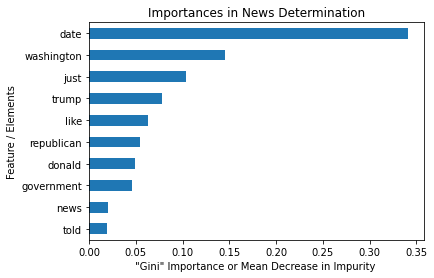

In [282]:
import matplotlib.pyplot as plt
importances = model1.named_steps['predictor'].feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('"Gini" Importance or Mean Decrease in Impurity ')
plt.ylabel('Feature / Elements')
plt.title('Importances in News Determination');

In [21]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'date'

# Build your `pdp_isolate`

isolate = pdp_isolate(
    model=model1,
    dataset=X_test, #<-- Always use with VALIDATION or TEST data
    model_features=X_test.columns,
    feature=feature
)

# Build your plot
pdp_plot(isolate, feature_name=feature);

NameError: name 'model1' is not defined

# IF the user copy / pastes the text - then we don't need to scrape into a CSV or whatever, we can just vectorize and model... 
# This means plotly, dash, heroku, could actually be achievable. 